In [3]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')

original_corpus = pd.read_csv('data/mental_health.csv')
cleaned_corpus = pd.read_csv('data/cleaned_mhc.csv')

print("Shape of Original Corpus", original_corpus.shape)
print("Shape of Cleaned Corpus", cleaned_corpus.shape)

Shape of Original Corpus (27977, 2)
Shape of Cleaned Corpus (23240, 2)


In [4]:
# param_grid = {
#     'random_state': [42, 123, 256, 789, 101],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]
# }

param_grid = {
    'random_state': [42],
    'criterion': ['gini'],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt', 'log2', None]
}

metrics_original_rf = {"Params": [], "Train Accuracy": [], "Test Accuracy": [], "Precision": [], "Recall": [], "F1": [], "Test Time (s)": []}
metrics_cleaned_rf = {"Params": [], "Train Accuracy": [], "Test Accuracy": [], "Precision": [], "Recall": [], "F1": [], "Test Time (s)": []}

def run_rf_grid_search(corpus, target, metrics_dict, dataset_name):
    best_f1 = 0
    best_conf_matrix = None
    best_params = None
    best_test_time = None

    X_train, X_test, y_train, y_test = train_test_split(corpus, target, test_size=0.2, random_state=42)
    vectorizer = TfidfVectorizer(max_features=3500)
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    rf = DecisionTreeClassifier()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)

    grid_search.fit(X_train_tfidf, y_train)

    for params, mean_score, std_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['std_test_score']):
        best_rf = grid_search.best_estimator_

        start_test = time.perf_counter()
        y_pred = best_rf.predict(X_test_tfidf)
        test_time = time.perf_counter() - start_test

        train_acc = accuracy_score(y_train, best_rf.predict(X_train_tfidf))
        test_acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        metrics_dict["Params"].append(params)
        metrics_dict["Train Accuracy"].append(train_acc)
        metrics_dict["Test Accuracy"].append(test_acc)
        metrics_dict["Precision"].append(prec)
        metrics_dict["Recall"].append(rec)
        metrics_dict["F1"].append(f1)
        metrics_dict["Test Time (s)"].append(test_time)

        if f1 > best_f1:
            best_f1 = f1
            best_conf_matrix = confusion_matrix(y_test, y_pred)
            best_params = params
            best_test_time = test_time

    print(f"Best F1 Score for {dataset_name} Corpus (Params={best_params}): {best_f1:.4f}, "
          f"Test time: {best_test_time:.4f} s")
    print("Confusion Matrix:\n", best_conf_matrix)
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

run_rf_grid_search(original_corpus['text'], original_corpus['label'], metrics_original_rf, "Original")
run_rf_grid_search(cleaned_corpus['text'], cleaned_corpus['label'], metrics_cleaned_rf, "Cleaned")

df_original_rf = pd.DataFrame(metrics_original_rf)
df_cleaned_rf = pd.DataFrame(metrics_cleaned_rf)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best F1 Score for Original Corpus (Params={'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}): 0.8296, Test time: 0.0016 s
Confusion Matrix:
 [[2509  293]
 [ 606 2188]]
Train Accuracy: 0.9068, Test Accuracy: 0.8393, Precision: 0.8819, Recall: 0.7831, F1: 0.8296
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best F1 Score for Cleaned Corpus (Params={'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}): 0.8413, Test time: 0.0012 s
Confusion Matrix:
 [[1812  287]
 [ 490 2059]]
Train Accuracy: 0.9161, Test Accuracy: 0.8328, Precision: 0.8777, Recall: 0.8078, F1: 0.8413


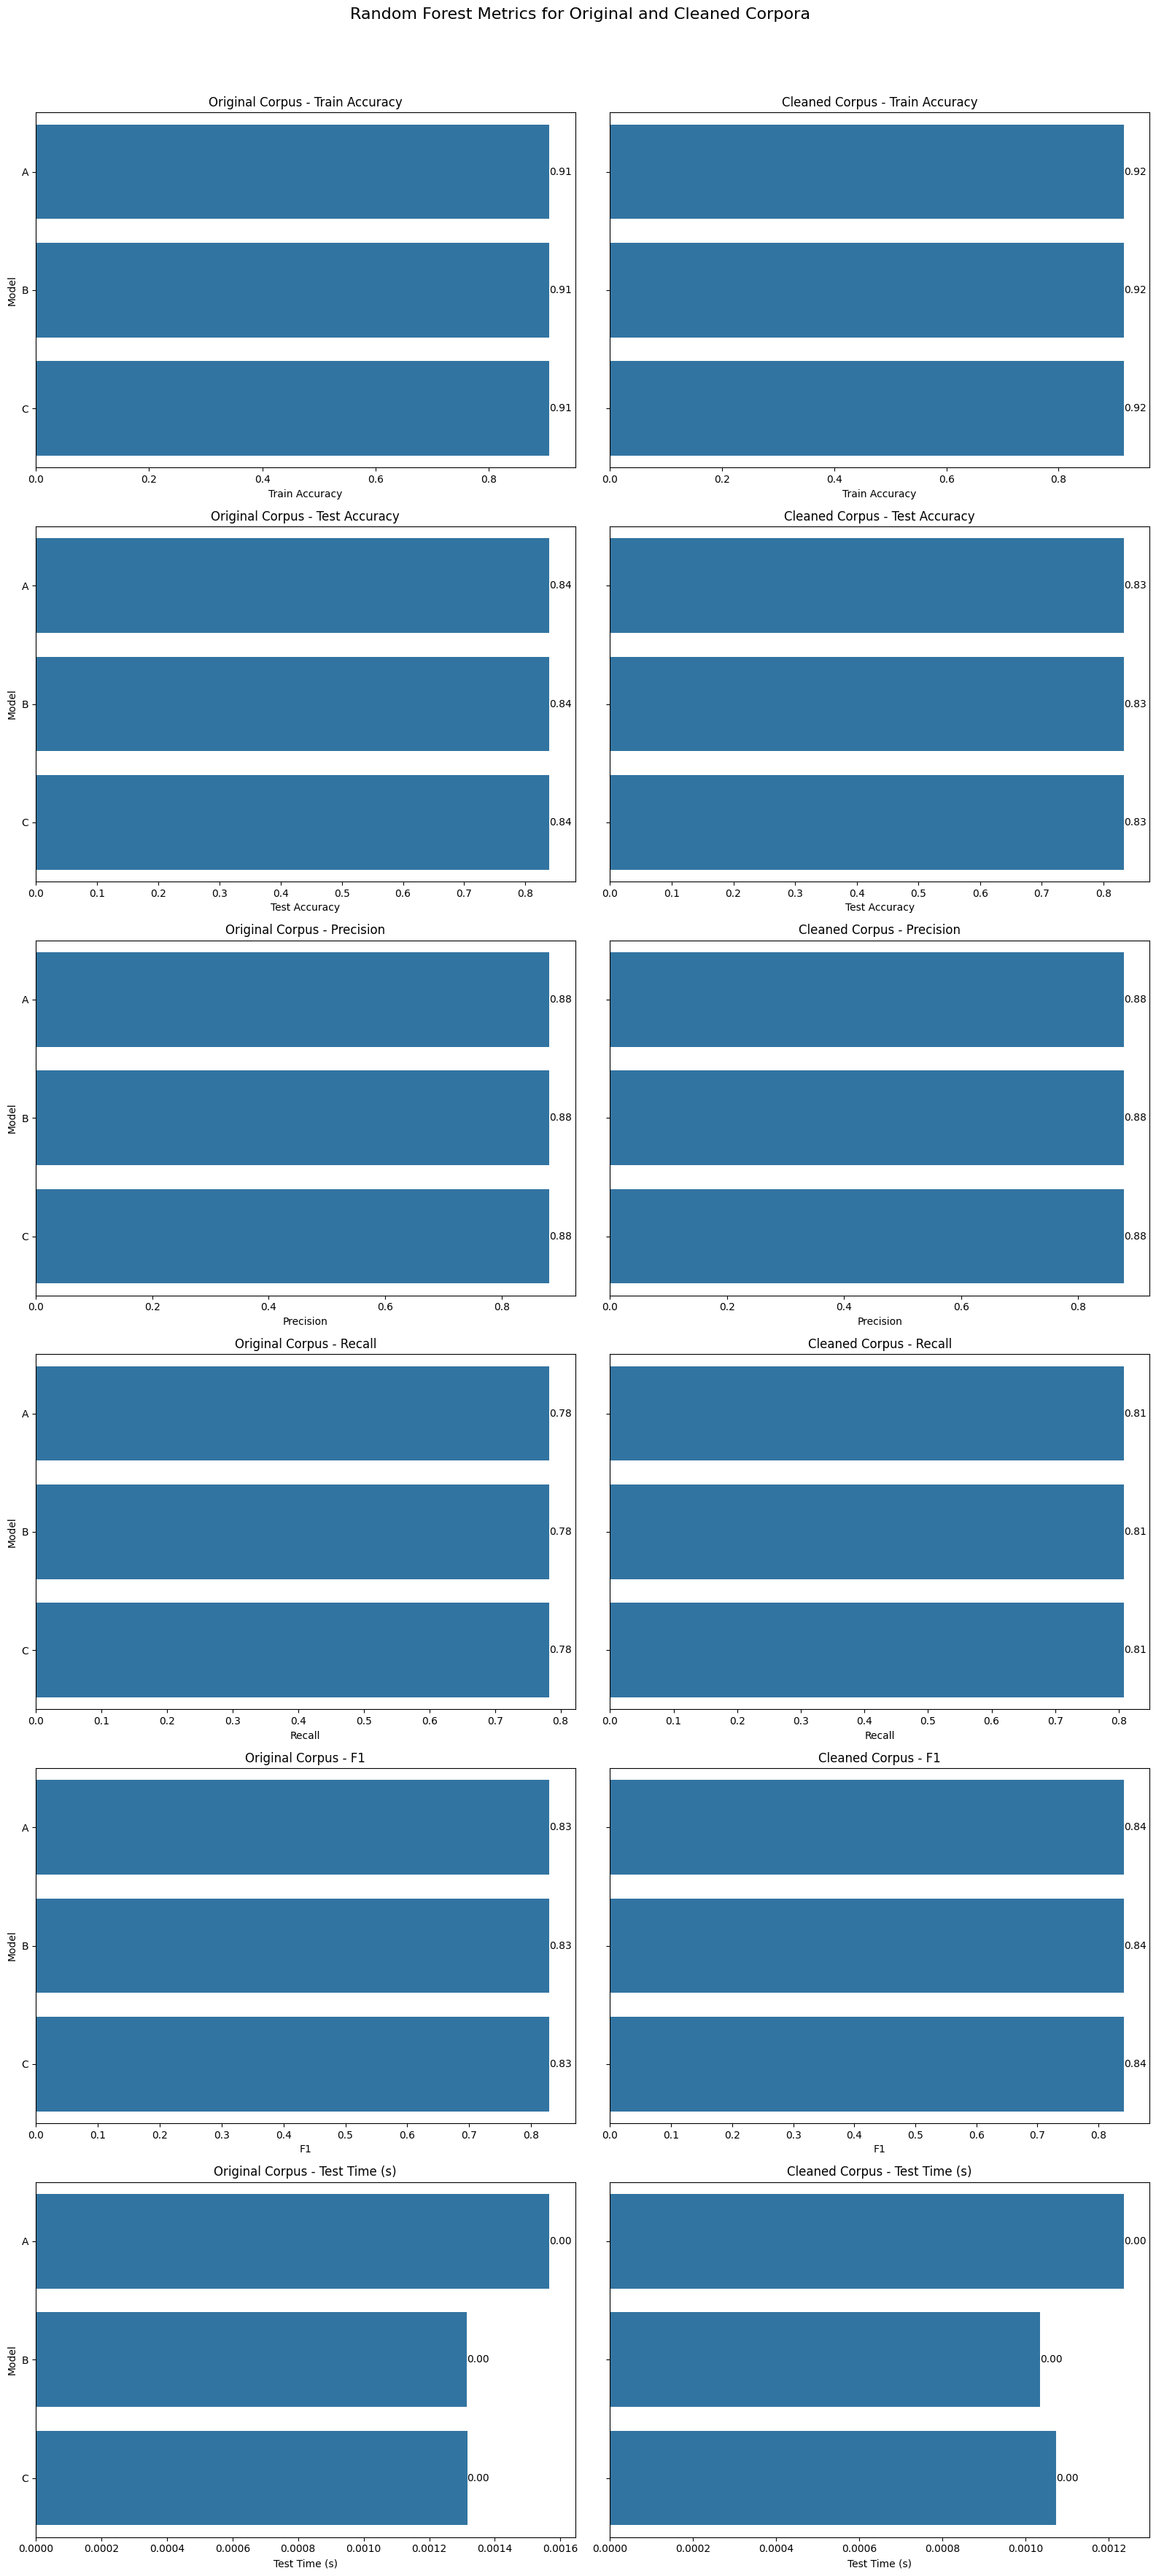


Original Corpus Models and Parameters:
Model A: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}
Model B: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}
Model C: {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}

Cleaned Corpus Models and Parameters:
Model A: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}
Model B: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}
Model C: {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}


In [5]:
df_original_rf["Model"] = [string.ascii_uppercase[i] for i in range(len(df_original_rf))]
df_cleaned_rf["Model"] = [string.ascii_uppercase[i] for i in range(len(df_cleaned_rf))]

metrics_to_plot = ["Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1", "Test Time (s)"]

fig, axes = plt.subplots(len(metrics_to_plot), 2, figsize=(16, 36), sharey=True)
fig.suptitle("Random Forest Metrics for Original and Cleaned Corpora", fontsize=16)

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(ax=axes[i, 0], y="Model", x=metric, data=df_original_rf, orient='h')
    axes[i, 0].set_title(f"Original Corpus - {metric}")
    axes[i, 0].bar_label(axes[i, 0].containers[0], fmt='%.2f', label_type='edge')

    sns.barplot(ax=axes[i, 1], y="Model", x=metric, data=df_cleaned_rf, orient='h')
    axes[i, 1].set_title(f"Cleaned Corpus - {metric}")
    axes[i, 1].bar_label(axes[i, 1].containers[0], fmt='%.2f', label_type='edge')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\nOriginal Corpus Models and Parameters:")
for idx, row in df_original_rf.iterrows():
    print(f"Model {row['Model']}: {row['Params']}")

print("\nCleaned Corpus Models and Parameters:")
for idx, row in df_cleaned_rf.iterrows():
    print(f"Model {row['Model']}: {row['Params']}")